# 2021 CVE Data Review

This notebook will pull all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and performs some basic data analysis of CVEd data. 

## Getting Started

### Collecting Data

This cell pulls all JSON files from the NVD that we will be working with.

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2020..2021}.json.zip 
!unzip -o "*.zip" 

### Import Python Libraries

In [2]:
import calplot
import glob
import logging
import json
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import re
import uuid
import warnings
from datetime import datetime


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")


# 2021 CVE Data

### Build Base DataFrame

This code builds a Panda dataframe from the JSON files we downloaded, removing all CVE's marked rejected.

In [3]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-2021.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('**'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd_2021 = pd.DataFrame(row_accumulator)
    

day_of_year = datetime.now().timetuple().tm_yday
nvd_2021 = nvd_2021[(nvd_2021['Published'] > '2021-01-01') & (nvd_2021['Published'] < '2021-10-1')]
nvd_2021['Published'] = pd.to_datetime(nvd_2021['Published']).apply(lambda x: x.date())
print ('CVEs from NVD:', nvd_2021['CVE'].count())
nvdcount = nvd_2021['Published'].count()
per_day = nvdcount/day_of_year
per_day = round(per_day, 0)
print('CVEs Published Per Day:', per_day)

CVEs from NVD: 11245
CVEs Published Per Day: 41.0


### CVEs Per Day Graph

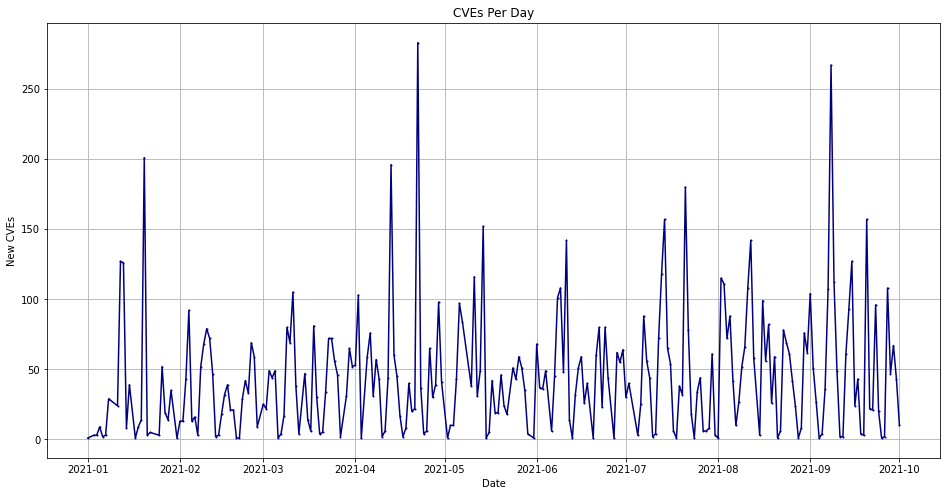

In [4]:
nvd_data_2021 = nvd_2021['Published'].value_counts()
cg = nvd_data_2021.plot(colormap='jet', marker='.', figsize=(16, 8), markersize=2, title='CVEs Per Day')
plt.grid()
cg.set_ylabel("New CVEs")
cg.set_xlabel("Date")
plt.savefig('2021.jpg', dpi=300, bbox_inches='tight')

### Most CVEs Per Day 

In [5]:
nvd_2021['Published'].value_counts().head(10)

2021-04-22    283
2021-09-08    267
2021-01-20    201
2021-04-13    196
2021-07-21    180
2021-07-14    157
2021-09-20    157
2021-05-14    152
2021-06-11    142
2021-08-12    142
Name: Published, dtype: int64

# CVSS 3 Breakdown

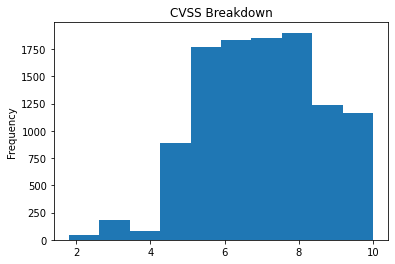

In [6]:
nvd_2021['BaseScore'] = pd.to_numeric(nvd_2021['BaseScore']);
nvd_2021['BaseScore'] = nvd_2021['BaseScore'].replace(0, np.NaN);
nvd_2021['BaseScore'].plot(kind="hist", title='CVSS Breakdown');
plt.savefig('2021CVSS.jpg', dpi=300, bbox_inches='tight')

Average CVSS Score:

In [7]:
nvd_2021['BaseScore'].mean()

7.044296160877513

# 2020 CVE Data

### Build Base DataFrame

This code builds a Panda dataframe from the JSON files we downloaded, removing all CVE's marked rejected.

In [8]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-2020.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd_2020 = pd.DataFrame(row_accumulator)
    

nvd_2020 = nvd_2020[(nvd_2020['Published'] > '2020-01-01') & (nvd_2020['Published'] < '2020-10-01')]
nvd_2020['Published'] = pd.to_datetime(nvd_2020['Published']).apply(lambda x: x.date())
print ('CVEs from NVD:', nvd_2020['CVE'].count())
nvdcount = nvd_2020['Published'].count()
per_day = nvdcount/244
per_day = round(per_day, 0)
print('CVEs Published Per Day:', per_day)

CVEs from NVD: 10211
CVEs Published Per Day: 42.0


### CVEs Per Day Graph

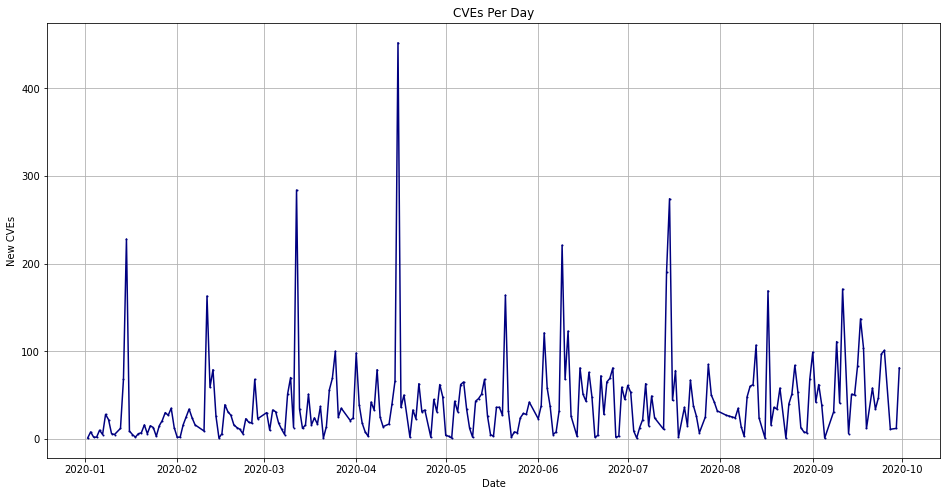

In [9]:
nvd_data_2020 = nvd_2020['Published'].value_counts()
cg = nvd_data_2020.plot(colormap='jet', marker='.', figsize=(16, 8), markersize=2, title='CVEs Per Day')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");
plt.savefig('2020.jpg', dpi=300, bbox_inches='tight')

### Most CVEs Per Day 

In [10]:
nvd_2020['Published'].value_counts().head(10)

2020-04-15    452
2020-03-12    284
2020-07-15    274
2020-01-15    228
2020-06-09    221
2020-07-14    190
2020-09-11    171
2020-08-17    169
2020-05-21    164
2020-02-11    163
Name: Published, dtype: int64

### CVE Heat Map

# CVSS 3 Breakdown

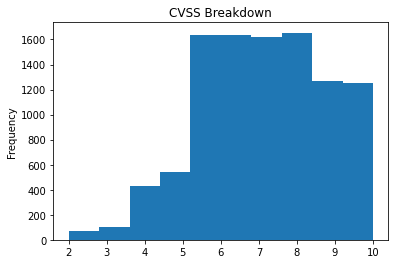

In [11]:
nvd_2020['BaseScore'] = pd.to_numeric(nvd_2020['BaseScore']);
nvd_2020['BaseScore'] = nvd_2020['BaseScore'].replace(0, np.NaN);
nvd_2020['BaseScore'].plot(kind="hist", title='CVSS Breakdown');
plt.savefig('2020CVSS.jpg', dpi=300, bbox_inches='tight')

Average CVSS Score:

In [12]:
nvd_2020['BaseScore'].mean()

7.115561649201841